In [2]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from unidecode import unidecode
import datetime as dt
import requests
import statsapi


In [ ]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

In [22]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [ ]:
print(data23.columns.tolist())

In [23]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

In [24]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]

In [25]:
data20_22['p_throws'] = data20_22['p_throws'].map({'L': 0, 'R': 1})
data23['p_throws'] = data23['p_throws'].map({'L': 0, 'R': 1})

data20_22['stand'] = data20_22['stand'].map({'L': 0, 'R': 1})
data23['stand'] = data23['stand'].map({'L': 0, 'R': 1})

In [26]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [27]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [28]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [29]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [30]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)


#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['calc_spin'] = np.arctan2(df['pfx_x'],df['pfx_z']) * (180 / np.pi)
    df['axis_dif'] = np.abs(df['calc_spin'] - df['spin_axis'])
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)


def find_most_common_fastball(df):
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)


In [31]:
# Combining Fastball, Sinker, and Cutter into one dataframe
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]

# Combining Slider and Sweeper into one dataframe
breakingball_20_22 = data20_22[data20_22.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]
breakingball_23 = data23[data23.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]

# Combining Changeup and Splitter into one dataframe
offspeed_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup', 'Splitter'])]
offspeed_23 = data23[data23.pitch_type.isin(['Changeup', 'Splitter'])]

In [33]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff','game_year']
fball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif','game_year']

In [34]:
#Split into train and test

fastball_x = fastball_20_22[fball_features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

breakingball_x = breakingball_20_22[features]
breakingball_y = breakingball_20_22['delta_run_exp']

x_train_breakingball, x_test_breakingball, y_train_breakingball, y_test_breakingball = train_test_split(breakingball_x, breakingball_y, train_size=0.75, random_state=12345)

offspeed_x = offspeed_20_22[features]
offspeed_y = offspeed_20_22['delta_run_exp']

x_train_offspeed, x_test_offspeed, y_train_offspeed, y_test_offspeed = train_test_split(offspeed_x, offspeed_y, train_size=0.75, random_state=12345)



In [35]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
breakingball_model = CatBoostRegressor(**params)
breakingball_model.fit(x_train_breakingball, y_train_breakingball)

#Cutter
offspeed_model = CatBoostRegressor(**params)
offspeed_model.fit(x_train_offspeed, y_train_offspeed)

0:	learn: 0.2452020	total: 25.4ms	remaining: 12.7s
1:	learn: 0.2451944	total: 47.9ms	remaining: 11.9s
2:	learn: 0.2451859	total: 71.9ms	remaining: 11.9s
3:	learn: 0.2451784	total: 91.9ms	remaining: 11.4s
4:	learn: 0.2451710	total: 113ms	remaining: 11.2s
5:	learn: 0.2451656	total: 133ms	remaining: 11s
6:	learn: 0.2451603	total: 152ms	remaining: 10.7s
7:	learn: 0.2451551	total: 171ms	remaining: 10.5s
8:	learn: 0.2451503	total: 188ms	remaining: 10.3s
9:	learn: 0.2451470	total: 206ms	remaining: 10.1s
10:	learn: 0.2451431	total: 226ms	remaining: 10.1s
11:	learn: 0.2451401	total: 245ms	remaining: 9.97s
12:	learn: 0.2451363	total: 268ms	remaining: 10.1s
13:	learn: 0.2451327	total: 288ms	remaining: 9.99s
14:	learn: 0.2451291	total: 305ms	remaining: 9.88s
15:	learn: 0.2451266	total: 322ms	remaining: 9.74s
16:	learn: 0.2451240	total: 340ms	remaining: 9.67s
17:	learn: 0.2451209	total: 386ms	remaining: 10.3s
18:	learn: 0.2451190	total: 406ms	remaining: 10.3s
19:	learn: 0.2451164	total: 425ms	remai

In [36]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])

breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])

offspeed_23['pred'] = offspeed_model.predict(offspeed_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_92656/3149739183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_92656/3149739183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_92656/3149739183.py:6: SettingWithCopyWarni

In [37]:
combined_df = pd.concat([fastball_23, breakingball_23, offspeed_23])

def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(combined_df)

fastball_23 = combined_df[combined_df.pitch_type == 'Fastball']
sinker_23 = combined_df[combined_df.pitch_type == 'Sinker']
cutter_23 = combined_df[combined_df.pitch_type == 'Cutter']
slider_23 = combined_df[combined_df.pitch_type == 'Slider']
sweeper_23 = combined_df[combined_df.pitch_type == 'Sweeper']
curveball_23 = combined_df[combined_df.pitch_type == 'Curveball']
changeup_23 = combined_df[combined_df.pitch_type == 'Changeup']
splitter_23 = combined_df[combined_df.pitch_type == 'Splitter']


In [38]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [39]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 100
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores_testing_24.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
860,"deGrom, Jacob",115.84,111.69,0.00,0.00,123.01,0.00,105.23,111.40,0.0
311,"Helsley, Ryan",115.55,114.44,0.00,0.00,119.78,0.00,102.29,0.00,0.0
387,"Kerkering, Orion",114.48,104.09,101.49,0.00,0.00,118.49,0.00,0.00,0.0
336,"Holmes, Clay",113.52,0.00,114.12,0.00,112.04,112.40,0.00,0.00,0.0
773,"Uribe, Abner",112.04,103.83,109.91,0.00,117.62,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
197,"Doyle, Tommy",84.34,88.52,98.49,79.09,89.29,0.00,0.00,0.00,0.0
434,"Little, Luke",84.07,90.40,0.00,0.00,0.00,74.87,0.00,0.00,0.0
813,"Weber, Ryan",82.88,0.00,96.73,0.00,87.71,0.00,0.00,20.94,0.0
517,"Miller, Tyson",79.43,107.59,83.91,0.00,75.53,0.00,-41.99,91.58,0.0


In [42]:
combined_data.sort_values(by='overall', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
860,"deGrom, Jacob",115.84,111.69,0.00,0.00,123.01,0.00,105.23,111.40,0.00
311,"Helsley, Ryan",115.55,114.44,0.00,0.00,119.78,0.00,102.29,0.00,0.00
387,"Kerkering, Orion",114.48,104.09,101.49,0.00,0.00,118.49,0.00,0.00,0.00
336,"Holmes, Clay",113.52,0.00,114.12,0.00,112.04,112.40,0.00,0.00,0.00
773,"Uribe, Abner",112.04,103.83,109.91,0.00,117.62,0.00,0.00,0.00,0.00
612,"Pressly, Ryan",111.71,103.87,101.47,101.71,114.34,0.00,116.31,107.93,0.00
188,"Diaz, Alexis",111.48,119.06,0.00,0.00,104.32,0.00,0.00,0.00,0.00
218,"Fairbanks, Pete",111.24,113.74,0.00,0.00,108.99,0.00,0.00,93.33,0.00
216,"Estrada, Jeremiah",111.08,112.70,0.00,0.00,102.80,0.00,96.11,102.43,0.00
139,"Clase, Emmanuel",110.87,103.16,0.00,107.79,117.43,0.00,0.00,0.00,0.00


In [237]:
mean_data = combined_data['fastball']
mean_data = mean_data[mean_data !=0]
mean_data.mean()

98.9624961715161

In [238]:
my_value = 'Houck, Tanner'
results = combined_data.loc[combined_data["player_name"] == my_value]
results

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
339,"Houck, Tanner",101.07,99.25,106.07,97.4,99.1,0.0,0.0,0.0,100.03


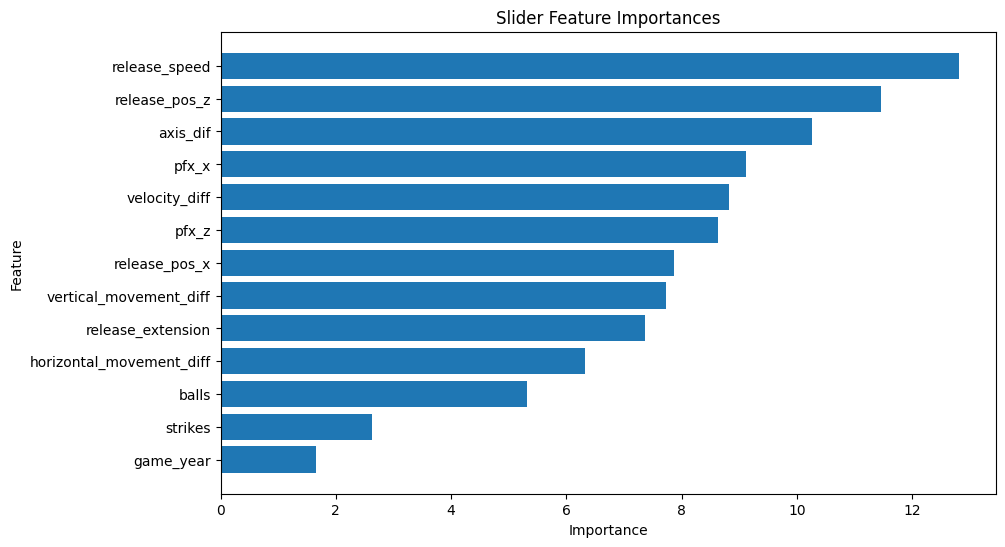

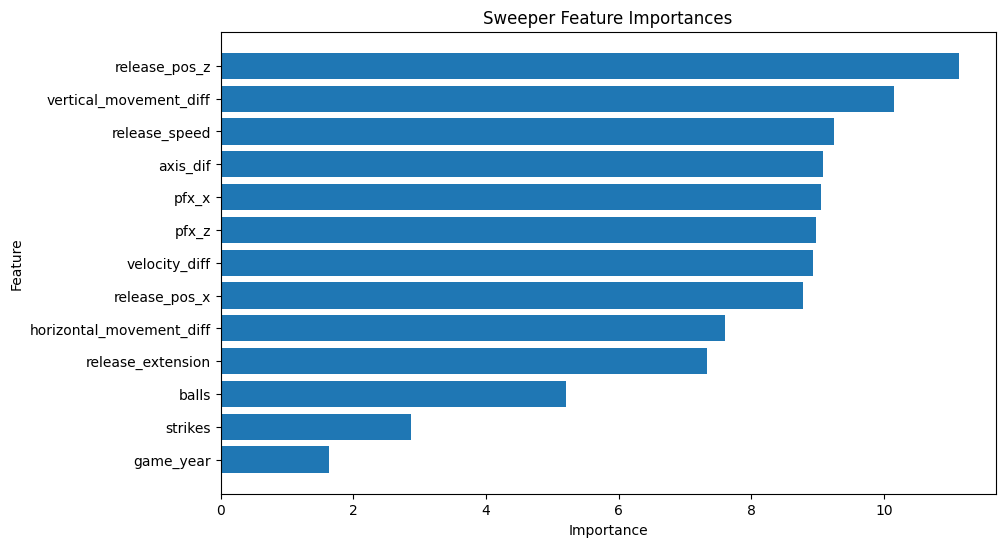

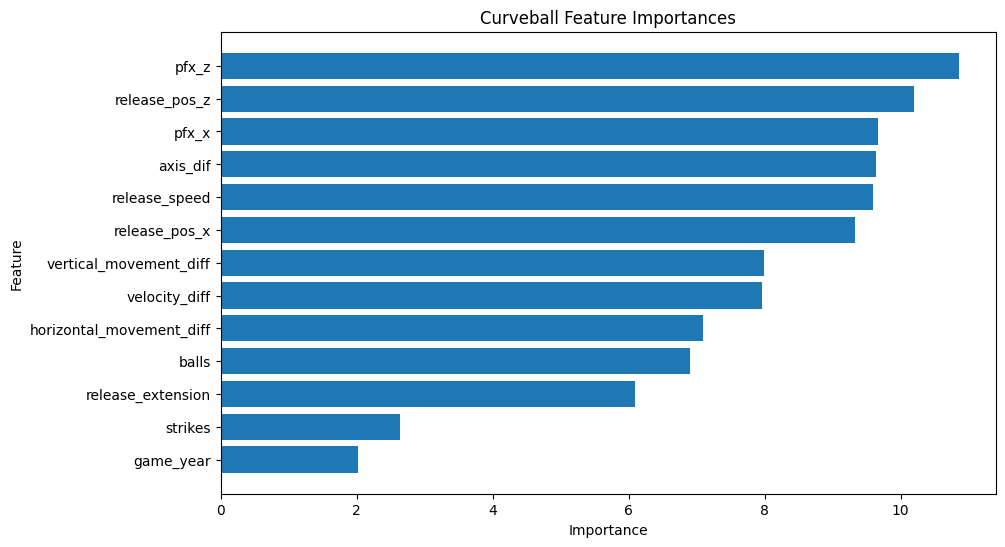

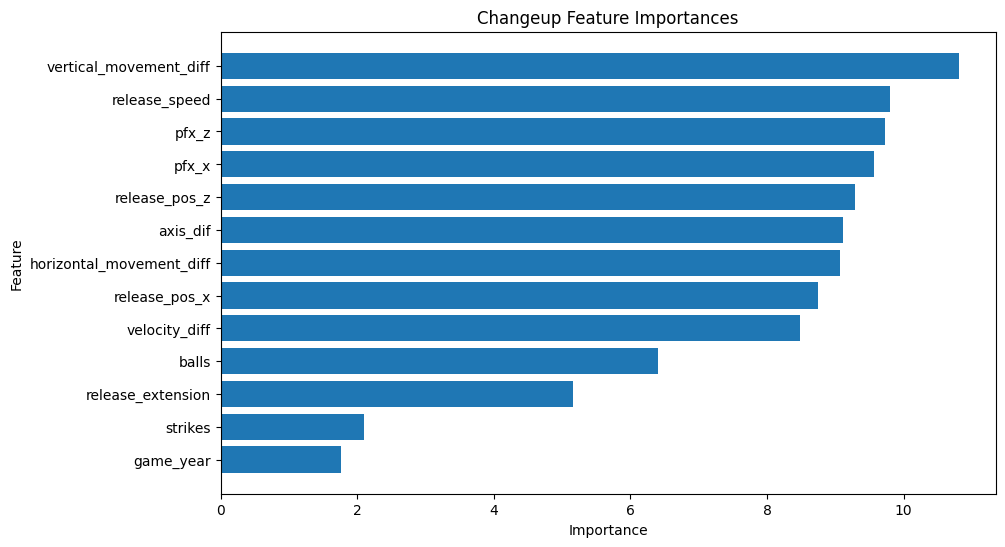

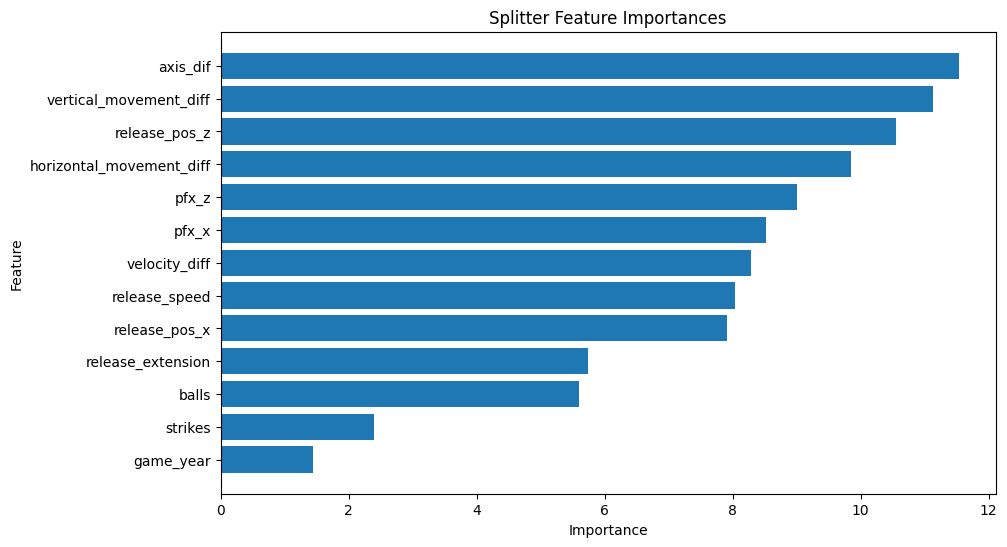

In [142]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()




#plot_feature_importances(fastball_model, features, 'Fastball Feature Importances')
#plot_feature_importances(sinker_model, features, 'Sinker Feature Importances')
#plot_feature_importances(cutter_model, features, 'Cutter Feature Importances')
plot_feature_importances(slider_model, features, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, features, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, features, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, features, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, features, 'Splitter Feature Importances')